In [1]:
import os 
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_data(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data.Group == 'AD') | (data.Group == 'CN'))]
    return data


In [3]:
path = str(Path().resolve())
path = path + "/ADNI1/"
filename = os.listdir(path)[2]
n_mmni_filename = os.path.join(path, filename)
img_n_mmni = nib.load(n_mmni_filename)


In [6]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = get_data(path)
y_data.head()


,Rooster ID,Group
Subject ID,,
002_S_0295,295,CN
002_S_0413,413,CN
002_S_0559,559,CN
002_S_0619,619,AD
002_S_0685,685,CN


# Data preparation & splitting 

In [10]:
from tensorflow.keras.utils import to_categorical


def Data_preparation(Y):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename).get_fdata()
            
            # hippocampe n°1 :
            
            hipp1 = img_n_mmni[40:80,90:130,40:80]
            X_data.append(hipp1)
            if Y['Group'][index] == 'AD':
                Y_data.append(1)
            elif Y['Group'][index] == 'CN':
                Y_data.append(0)
            
            
            # hippocampe n°2 :
            
            hipp2 = img_n_mmni[110:140,90:130,0:80]
            X_data.append(hipp1)
            if Y['Group'][index] == 'AD':
                Y_data.append(1)
            elif Y['Group'][index] == 'CN':
                Y_data.append(0)    
            
        else:
            Y.drop(index, inplace=True)
        
    X_data = np.array(X_data)   
    return X_data, Y_data





2022-12-08 16:50:46.877179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 16:50:47.740955: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/coleger/miniconda3/envs/tf/lib/
2022-12-08 16:50:47.741017: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/coleger/miniconda3/envs/tf/lib/
2022-12-08 16:50:47.741023: W tensorflow/compiler/tf

In [11]:
X_data, Y_data = Data_preparation(y_data)
Y_data = to_categorical(Y_data, num_classes=2)

print(X_data.shape)
print(len(Y_data))

(838, 40, 40, 40)
838


In [20]:
# on garde seulement une colonne pour y 
y_data = np.argmax(Y_data, axis= 1)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=49) 

print("Data splited, length of training data is: ", len(X_train))
print("Data splited, length of test data is: ", len(X_test))

Data splited, length of training data is:  670
Data splited, length of test data is:  168


# Creation of Conv3D model

In [22]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization

model = Sequential()
# Couches de convolution + MaxPooling
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(40,40,40,1)))
# input shape = (batch_size, channels, dim1, dim2,dim3)
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.3))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.3))
# Couches de classification
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

    

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 38, 38, 38, 32)    896       
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 19, 19, 19, 32)   0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 19, 19, 19, 32)   128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 19, 19, 19, 32)    0         
                                                                 
 conv3d_5 (Conv3D)           (None, 17, 17, 17, 64)    55360     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 8, 8, 8, 64)     

# Training with CN et AD data 

In [23]:
import tensorflow as tf
# ajout d'un early stopping 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=80, validation_data=(X_test, y_test),callbacks=[callback],batch_size=2)

Epoch 1/80


2022-12-08 16:55:26.801406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-08 16:55:27.530753: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-08 16:55:28.309489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


335/335 [==============================] - 6s 8ms/step - loss: 2.5170 - accuracy: 0.6701 - val_loss: 1.8998 - val_accuracy: 0.5060
Epoch 2/80
335/335 [==============================] - 2s 7ms/step - loss: 0.6167 - accuracy: 0.8194 - val_loss: 0.9419 - val_accuracy: 0.7917
Epoch 3/80
335/335 [==============================] - 2s 7ms/step - loss: 0.3519 - accuracy: 0.8836 - val_loss: 1.0778 - val_accuracy: 0.6726
Epoch 4/80
335/335 [==============================] - 2s 7ms/step - loss: 0.3968 - accuracy: 0.8970 - val_loss: 0.1861 - val_accuracy: 0.9226
Epoch 5/80
335/335 [==============================] - 2s 7ms/step - loss: 0.2106 - accuracy: 0.9493 - val_loss: 0.4424 - val_accuracy: 0.8869
Epoch 6/80
335/335 [==============================] - 2s 7ms/step - loss: 0.1815 - accuracy: 0.9403 - val_loss: 0.2823 - val_accuracy: 0.8810
Epoch 7/80
335/335 [==============================] - 2s 7ms/step - loss: 0.0604 - accuracy: 0.9776 - val_loss: 0.7988 - val_accuracy: 0.7560
Epoch 8/80
335/33

# Plotting metrics 

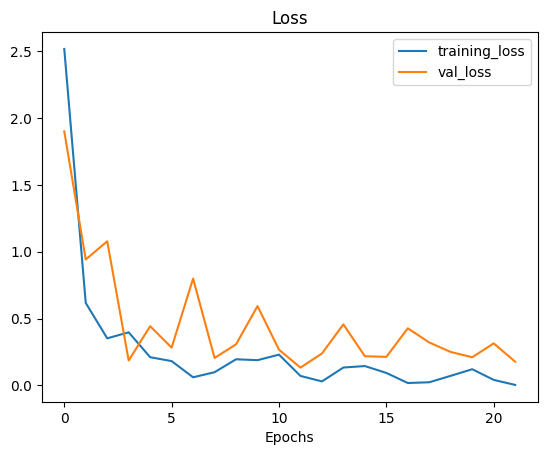

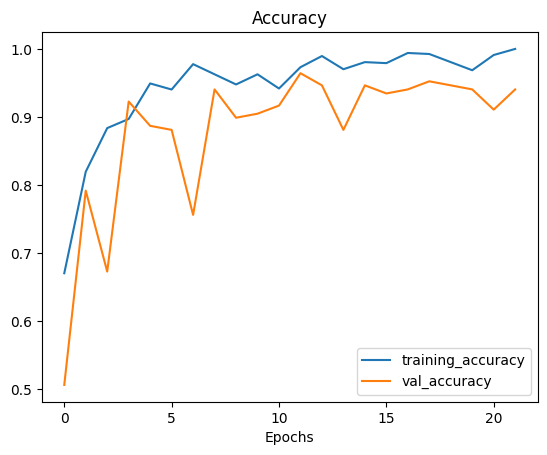

In [24]:
def plot_loss_curves(history):
    
      
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(history)

In [25]:
best_val_accuracy = np.max(history.history['val_accuracy'])
print(' Best val_accuracy value : {} '.format(best_val_accuracy))

 Best val_accuracy value : 0.9642857313156128 


# Testing with pMCI et sMCI data 

- pMCI ~ AD ==1
- sMCI ~ CN ==0

In [36]:
def get_data_MCI(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group','Conversion'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data['Conversion'] == 1) | (data['Conversion'] == 2) | (data['Conversion'] == 3) | (data['Conversion'] == 4))]
    return data


In [37]:
path = str(Path().resolve())
path = path + "/ADNI1/"
filename = os.listdir(path)[2]
n_mmni_filename = os.path.join(path, filename)
img_n_mmni = nib.load(n_mmni_filename)


In [38]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = get_data_MCI(path)
y_data.head()


,Rooster ID,Group,Conversion
Subject ID,,,
002_S_0729,729,MCI,3
002_S_0782,782,MCI,4
002_S_0954,954,MCI,3
002_S_1070,1070,MCI,3
002_S_1155,1155,MCI,4


# Data preparation & splitting 

In [39]:
from tensorflow.keras.utils import to_categorical


def Data_preparation_MCI(Y):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename).get_fdata()
            
            # hippocampe n°1 :
            
            hipp1 = img_n_mmni[40:80,90:130,40:80]
            X_data.append(hipp1)
            if Y['Conversion'][index] == 1 | Y['Conversion'][index] == 2 | Y['Conversion'][index] == 3 : # pMCI
                Y_data.append(1)
            elif Y['Conversion'][index] == 4 : #sMCI
                Y_data.append(0)
            
            
            # hippocampe n°2 :
            
            hipp2 = img_n_mmni[110:140,90:130,0:80]
            X_data.append(hipp1)
            if Y['Conversion'][index] == 1 | Y['Conversion'][index] == 2 | Y['Conversion'][index] == 3 : # pMCI
                Y_data.append(1)
            elif Y['Conversion'][index] == 4 : #sMCI
                Y_data.append(0)    
            
        else:
            Y.drop(index, inplace=True)
        
    X_data = np.array(X_data)   
    return X_data, Y_data





In [40]:
X_data, Y_data = Data_preparation_MCI(y_data)
Y_data = to_categorical(Y_data, num_classes=2)

print(X_data.shape)
print(len(Y_data))

(600, 40, 40, 40)
600


In [41]:
# on garde seulement une colonne pour y 
y_data = np.argmax(Y_data, axis= 1)

In [44]:
ypred = model.predict(X_data)

19/19 [==============================] - 1s 20ms/step


In [47]:
print(ypred[0:5])
print(np.max(ypred))
print(np.min(ypred))

[[8.9373207e-04]
 [8.9373207e-04]
 [9.9798882e-01]
 [9.9798882e-01]
 [9.6380769e-04]]
1.0
6.101658e-09


In [48]:
ypred = np.where(ypred > 0.5, 1, 0)
print (ypred[0:5])

[[0]
 [0]
 [1]
 [1]
 [0]]


In [49]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(ypred, y_data)
print('accuracy on MCI data based on CN and AD training : {} '.format(acc))

accuracy on MCI data based on CN and AD training : 0.6466666666666666 
